In [1]:
# !pip install transformers datasets torch scikit-learn matplotlib seaborn pandas numpy tqdm torch>=2.0.0 transformers>=4.30.0 datasets>=2.14.0

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

/home/kmgabidullin/dl/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


### В качестве датасета возьмем imdb

In [3]:
dataset = load_dataset("imdb")
SAMPLE_SIZE = 2000

train_dataset = dataset['train'].shuffle(seed=SEED).select(range(SAMPLE_SIZE))
test_dataset = dataset['test'].shuffle(seed=SEED).select(range(SAMPLE_SIZE // 2))

print(f"Размер обучающей выборки: {len(train_dataset)}, размер тестовой выборки: {len(test_dataset)}\n")
print(f"Text: {train_dataset[0]['text']}\nLabel: {train_dataset[0]['label']} (0=negative, 1=positive)")


Размер обучающей выборки: 2000, размер тестовой выборки: 1000

Text: There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier's plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it's the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...
Label: 1 (0=negative, 1=positive)


### В качетсве модели будем использовать gpt2

In [4]:
MODEL_NAME = "gpt2-xl"  # 48 слоев
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModel.from_pretrained(MODEL_NAME, output_hidden_states=True)
model = model.to(device)
model.eval()

print(f"Количество слоев: {model.config.n_layer}, размер скрытого слоя: {model.config.n_embd}")

Количество слоев: 48, размер скрытого слоя: 1600


### Извлеченем представления из всех слоев

In [5]:
def extract_layer_representations(texts, labels, batch_size=8, dataset_type='train', max_length=512):
    num_layers = model.config.n_layer + 1  # +1 для embedding слоя
    layer_representations = {i: [] for i in range(num_layers)}
    
    for i in tqdm(range(0, len(texts), batch_size), desc=f"Извлечение представлений из датасета {dataset_type}"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
        hidden_states = outputs.hidden_states
        
        for layer_idx in range(num_layers):
            layer_output = hidden_states[layer_idx].mean(dim=1).cpu().numpy()
            layer_representations[layer_idx].append(layer_output)
        
        if torch.cuda.is_available() and i % (batch_size * 2) == 0:
            torch.cuda.empty_cache()
    
    for layer_idx in range(num_layers):
        layer_representations[layer_idx] = np.vstack(layer_representations[layer_idx])
    
    labels_array = np.array(labels)
    
    return layer_representations, labels_array

train_representations, train_labels = extract_layer_representations(
    train_dataset['text'], 
    train_dataset['label'],
    batch_size=16,
    dataset_type='train'
)

test_representations, test_labels = extract_layer_representations(
    test_dataset['text'],
    test_dataset['label'],
    batch_size=16,
    dataset_type='test'
)

Извлечение представлений из датасета test: 100%|██████████| 63/63 [02:08<00:00,  2.04s/it]


### Для каждого слоя обучим классификатор

In [ ]:
def train_and_evaluate_classifier(X_train, y_train, X_test, y_test, layer_idx):
    clf = LogisticRegression(max_iter=1000, random_state=SEED, n_jobs=-1)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    
    metrics = {
        'layer': layer_idx,
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    return metrics, clf

results = []
classifiers = {}

num_layers = len(train_representations)

for layer_idx in tqdm(range(num_layers), desc="Обучение классификаторов"):
    X_train = train_representations[layer_idx]
    X_test = test_representations[layer_idx]
    
    metrics, clf = train_and_evaluate_classifier(
        X_train, train_labels,
        X_test, test_labels,
        layer_idx
    )
    
    results.append(metrics)
    classifiers[layer_idx] = clf
    
    print(f"Слой {layer_idx}: Accuracy={metrics['accuracy']:.4f}, "
          f"F1={metrics['f1_score']:.4f}, ROC-AUC={metrics['roc_auc']:.4f}")

results_df = pd.DataFrame(results)
results_df


Обучение классификаторов:   2%|▏         | 1/49 [00:03<03:02,  3.80s/it]

Слой 0: Accuracy=0.6550, F1=0.6302, ROC-AUC=0.7051


Обучение классификаторов:   4%|▍         | 2/49 [00:08<03:20,  4.27s/it]

Слой 1: Accuracy=0.8120, F1=0.8086, ROC-AUC=0.8998


Обучение классификаторов:   6%|▌         | 3/49 [00:13<03:38,  4.76s/it]

Слой 2: Accuracy=0.8430, F1=0.8403, ROC-AUC=0.9129


Обучение классификаторов:   8%|▊         | 4/49 [00:19<03:53,  5.18s/it]

Слой 3: Accuracy=0.8350, F1=0.8342, ROC-AUC=0.9142


Обучение классификаторов:  10%|█         | 5/49 [00:25<03:59,  5.45s/it]

Слой 4: Accuracy=0.8330, F1=0.8311, ROC-AUC=0.9096


Обучение классификаторов:  12%|█▏        | 6/49 [00:31<04:00,  5.60s/it]

Слой 5: Accuracy=0.8320, F1=0.8317, ROC-AUC=0.9098


Обучение классификаторов:  14%|█▍        | 7/49 [00:38<04:11,  5.98s/it]

Слой 6: Accuracy=0.8210, F1=0.8219, ROC-AUC=0.9074


Обучение классификаторов:  16%|█▋        | 8/49 [00:44<04:13,  6.19s/it]

Слой 7: Accuracy=0.8270, F1=0.8268, ROC-AUC=0.9078


Обучение классификаторов:  18%|█▊        | 9/49 [00:49<03:45,  5.64s/it]

Слой 8: Accuracy=0.8280, F1=0.8304, ROC-AUC=0.9090


Обучение классификаторов:  20%|██        | 10/49 [00:53<03:23,  5.22s/it]

Слой 9: Accuracy=0.8340, F1=0.8333, ROC-AUC=0.9132


Обучение классификаторов:  22%|██▏       | 11/49 [00:57<03:09,  4.99s/it]

Слой 10: Accuracy=0.8400, F1=0.8403, ROC-AUC=0.9158


Обучение классификаторов:  24%|██▍       | 12/49 [01:02<02:58,  4.81s/it]

Слой 11: Accuracy=0.8380, F1=0.8380, ROC-AUC=0.9172


Обучение классификаторов:  27%|██▋       | 13/49 [01:07<02:51,  4.76s/it]

Слой 12: Accuracy=0.8340, F1=0.8350, ROC-AUC=0.9146


Обучение классификаторов:  29%|██▊       | 14/49 [01:11<02:42,  4.64s/it]

Слой 13: Accuracy=0.8370, F1=0.8359, ROC-AUC=0.9201


Обучение классификаторов:  31%|███       | 15/49 [01:15<02:36,  4.60s/it]

Слой 14: Accuracy=0.8440, F1=0.8434, ROC-AUC=0.9202


Обучение классификаторов:  33%|███▎      | 16/49 [01:20<02:31,  4.60s/it]

Слой 15: Accuracy=0.8490, F1=0.8479, ROC-AUC=0.9274


Обучение классификаторов:  35%|███▍      | 17/49 [01:24<02:26,  4.57s/it]

Слой 16: Accuracy=0.8520, F1=0.8508, ROC-AUC=0.9249


Обучение классификаторов:  37%|███▋      | 18/49 [01:29<02:20,  4.52s/it]

Слой 17: Accuracy=0.8400, F1=0.8394, ROC-AUC=0.9246


Обучение классификаторов:  39%|███▉      | 19/49 [01:33<02:15,  4.51s/it]

Слой 18: Accuracy=0.8550, F1=0.8551, ROC-AUC=0.9356


Обучение классификаторов:  41%|████      | 20/49 [01:38<02:10,  4.49s/it]

Слой 19: Accuracy=0.8550, F1=0.8546, ROC-AUC=0.9395


Обучение классификаторов:  43%|████▎     | 21/49 [01:42<02:05,  4.49s/it]

Слой 20: Accuracy=0.8660, F1=0.8657, ROC-AUC=0.9422


Обучение классификаторов:  45%|████▍     | 22/49 [01:47<02:00,  4.48s/it]

Слой 21: Accuracy=0.8760, F1=0.8745, ROC-AUC=0.9490


Обучение классификаторов:  47%|████▋     | 23/49 [01:51<01:56,  4.48s/it]

Слой 22: Accuracy=0.8870, F1=0.8869, ROC-AUC=0.9540


Обучение классификаторов:  49%|████▉     | 24/49 [01:56<01:52,  4.48s/it]

Слой 23: Accuracy=0.8910, F1=0.8907, ROC-AUC=0.9561


Обучение классификаторов:  51%|█████     | 25/49 [02:00<01:47,  4.47s/it]

Слой 24: Accuracy=0.8920, F1=0.8911, ROC-AUC=0.9579


Обучение классификаторов:  53%|█████▎    | 26/49 [02:05<01:42,  4.44s/it]

Слой 25: Accuracy=0.8850, F1=0.8847, ROC-AUC=0.9575


Обучение классификаторов:  55%|█████▌    | 27/49 [02:09<01:36,  4.41s/it]

Слой 26: Accuracy=0.8920, F1=0.8926, ROC-AUC=0.9592


Обучение классификаторов:  57%|█████▋    | 28/49 [02:13<01:32,  4.39s/it]

Слой 27: Accuracy=0.8990, F1=0.8985, ROC-AUC=0.9605


Обучение классификаторов:  59%|█████▉    | 29/49 [02:18<01:27,  4.38s/it]

Слой 28: Accuracy=0.8980, F1=0.8978, ROC-AUC=0.9598


Обучение классификаторов:  61%|██████    | 30/49 [02:22<01:23,  4.39s/it]

Слой 29: Accuracy=0.8970, F1=0.8967, ROC-AUC=0.9587


Обучение классификаторов:  63%|██████▎   | 31/49 [02:26<01:19,  4.41s/it]

Слой 30: Accuracy=0.9000, F1=0.8992, ROC-AUC=0.9574


Обучение классификаторов:  65%|██████▌   | 32/49 [02:31<01:14,  4.39s/it]

Слой 31: Accuracy=0.8980, F1=0.8982, ROC-AUC=0.9590


Обучение классификаторов:  67%|██████▋   | 33/49 [02:35<01:10,  4.40s/it]

Слой 32: Accuracy=0.8890, F1=0.8898, ROC-AUC=0.9592


Обучение классификаторов:  69%|██████▉   | 34/49 [02:40<01:06,  4.42s/it]

Слой 33: Accuracy=0.8860, F1=0.8867, ROC-AUC=0.9575


Обучение классификаторов:  71%|███████▏  | 35/49 [02:44<01:01,  4.39s/it]

Слой 34: Accuracy=0.8940, F1=0.8940, ROC-AUC=0.9582


Обучение классификаторов:  73%|███████▎  | 36/49 [02:48<00:57,  4.39s/it]

Слой 35: Accuracy=0.8870, F1=0.8887, ROC-AUC=0.9597


Обучение классификаторов:  76%|███████▌  | 37/49 [02:53<00:52,  4.42s/it]

Слой 36: Accuracy=0.8860, F1=0.8878, ROC-AUC=0.9588


Обучение классификаторов:  78%|███████▊  | 38/49 [02:57<00:48,  4.40s/it]

Слой 37: Accuracy=0.8810, F1=0.8828, ROC-AUC=0.9580


Обучение классификаторов:  80%|███████▉  | 39/49 [03:02<00:44,  4.43s/it]

Слой 38: Accuracy=0.8860, F1=0.8871, ROC-AUC=0.9604


Обучение классификаторов:  82%|████████▏ | 40/49 [03:06<00:39,  4.40s/it]

Слой 39: Accuracy=0.8840, F1=0.8863, ROC-AUC=0.9605


Обучение классификаторов:  84%|████████▎ | 41/49 [03:10<00:35,  4.40s/it]

Слой 40: Accuracy=0.8840, F1=0.8856, ROC-AUC=0.9607


Обучение классификаторов:  86%|████████▌ | 42/49 [03:15<00:30,  4.37s/it]

Слой 41: Accuracy=0.8920, F1=0.8931, ROC-AUC=0.9605


Обучение классификаторов:  88%|████████▊ | 43/49 [03:19<00:26,  4.41s/it]

Слой 42: Accuracy=0.8920, F1=0.8926, ROC-AUC=0.9615


Обучение классификаторов:  90%|████████▉ | 44/49 [03:24<00:22,  4.41s/it]

Слой 43: Accuracy=0.8980, F1=0.8978, ROC-AUC=0.9603


Обучение классификаторов:  92%|█████████▏| 45/49 [03:28<00:17,  4.38s/it]

Слой 44: Accuracy=0.8970, F1=0.8965, ROC-AUC=0.9606


Обучение классификаторов:  94%|█████████▍| 46/49 [03:32<00:13,  4.34s/it]

Слой 45: Accuracy=0.8940, F1=0.8936, ROC-AUC=0.9609


Обучение классификаторов:  96%|█████████▌| 47/49 [03:37<00:08,  4.35s/it]

Слой 46: Accuracy=0.8920, F1=0.8918, ROC-AUC=0.9615


Обучение классификаторов:  98%|█████████▊| 48/49 [03:41<00:04,  4.38s/it]

Слой 47: Accuracy=0.8910, F1=0.8900, ROC-AUC=0.9600


Обучение классификаторов: 100%|██████████| 49/49 [03:43<00:00,  4.56s/it]

Слой 48: Accuracy=0.9110, F1=0.9106, ROC-AUC=0.9717


,layer,accuracy,f1_score,roc_auc
0,0,0.655,0.630225,0.705086
1,1,0.812,0.808554,0.899846
2,2,0.843,0.840285,0.912898
3,3,0.835,0.834171,0.914227
4,4,0.833,0.831143,0.909584
5,5,0.832,0.831663,0.909760
6,6,0.821,0.821891,0.907351
7,7,0.827,0.826827,0.907803
8,8,0.828,0.830375,0.908976
9,9,0.834,0.833333,0.913234


### Визуализация результатов


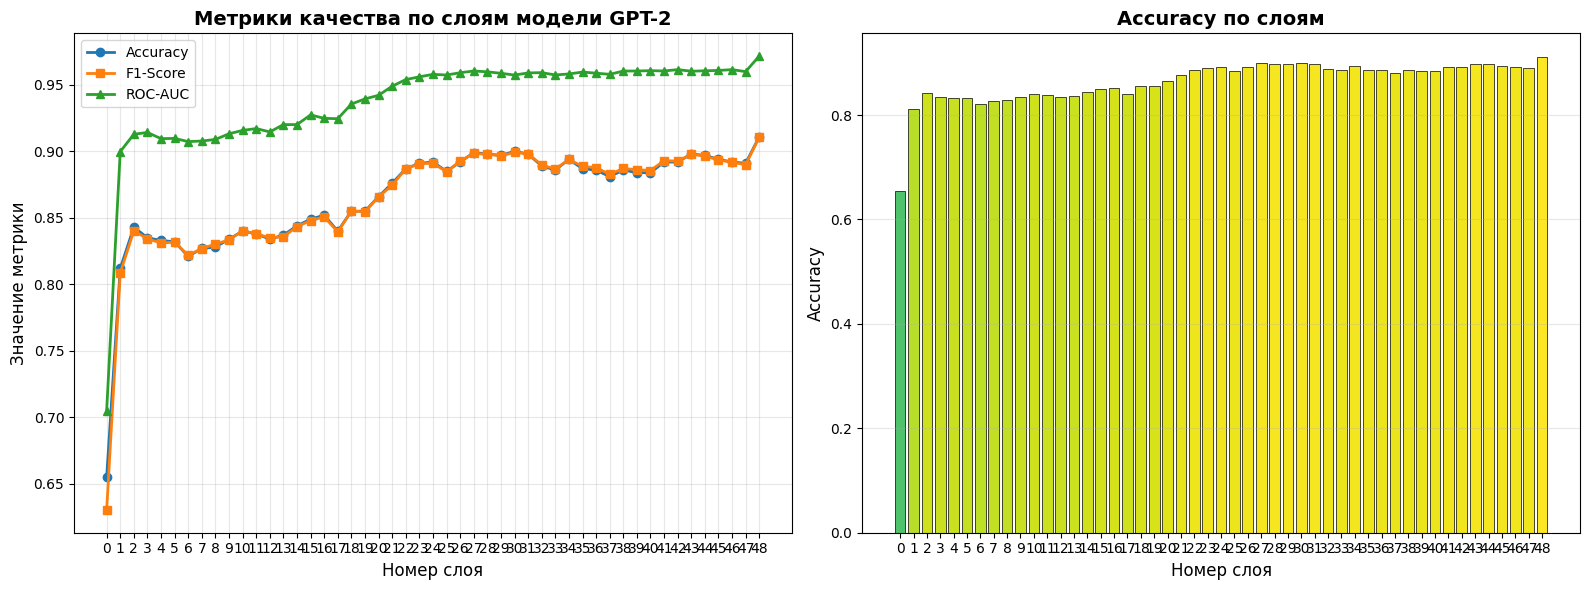

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График всех метрик по слоям
ax1 = axes[0]
ax1.plot(results_df['layer'], results_df['accuracy'], marker='o', label='Accuracy', linewidth=2)
ax1.plot(results_df['layer'], results_df['f1_score'], marker='s', label='F1-Score', linewidth=2)
ax1.plot(results_df['layer'], results_df['roc_auc'], marker='^', label='ROC-AUC', linewidth=2)
ax1.set_xlabel('Номер слоя', fontsize=12)
ax1.set_ylabel('Значение метрики', fontsize=12)
ax1.set_title('Метрики качества по слоям модели GPT-2', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(0, num_layers))

# Столбчатая диаграмма для Accuracy
ax2 = axes[1]
colors = plt.cm.viridis(results_df['accuracy'] / results_df['accuracy'].max())
bars = ax2.bar(results_df['layer'], results_df['accuracy'], color=colors, edgecolor='black', linewidth=0.5)
ax2.set_xlabel('Номер слоя', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Accuracy по слоям', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticks(range(0, num_layers))


plt.tight_layout()
plt.show()


В результате можно заметить, что действительно метрика accuracy примерно в средних слоях имеет чуть большее значение, чем слои слева и справа от них